In [1]:
import numpy as np
import os, sys
sys.path.append('../')
from bao_fitter import Data, Model, Fitter
import matplotlib.pyplot as plt

# Example notebook

This notebook shows how to call the Data, Model and Fitter classes in order to run a BAO fit.

The Data and Model classes are independent, while the Fitter class requires both a Data and a Model instance to get initialised.



## Data

In [2]:
d = Data(space='fourier', # can be fourier or configuration
         data_file='pk_multipoles.txt', 
         data_file_type='ascii', # a text file in this case, can use npy
         data_file_cols=(0,1,2),
         cov_file='covariance.npy', 
         cov_file_type='npy', # npy but can be ascii
         cov_npoles=2, # number of multipoles in the covariance file
         ell=(0,2), k_min=0.02, k_max=0.2,
         recon='recsym',
         Sigma_smooth=15.0) # it is actually needed for reciso only

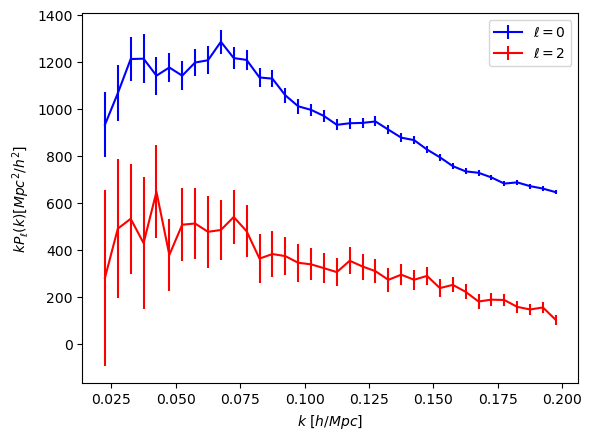

In [3]:
err = np.sqrt(d.cov.diagonal())
n = len(d.k)
colors = ['b', 'r', 'g']
for i, ell in enumerate([0, 2]):
    yerr = err[i*n:(i+1)*n]
    plt.errorbar(d.k, d.k * d.poles[i], yerr=d.k * yerr, color=colors[i], label=f'$\\ell={ell}$')
    plt.legend()
    plt.xlabel(r'$k~[h/Mpc]$')
    plt.ylabel(r'$k P_{\ell}(k) [Mpc^2/h^2]$')

## Model

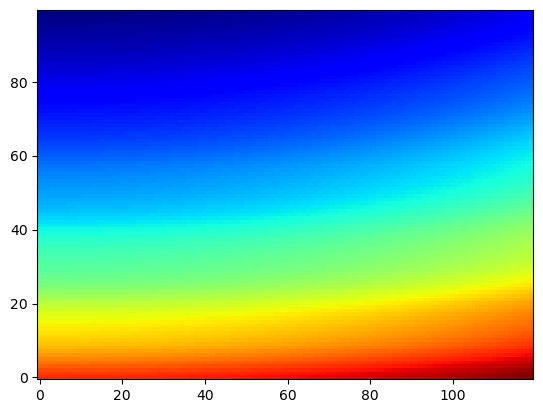

In [4]:
pk_lin = np.loadtxt('linearPk.txt', unpack=True) # Need a 2xN array with k, pklin. You can precompute this with CAMB or CLASS

# The model uses a parameter dictionary
# Parameters don't need to be set when running a fit,
# this is shown as an example
params = {'alpha_par': 1.0,
          'alpha_perp': 0.9,
          'bias': 1.1,
          'beta': 0.3,
          'Sigma_par': 4.,
          'Sigma_perp': 4.,
          'Sigma_s': 2.}


m = Model(pk_linear=pk_lin, params=params)

# You can compute the pk in 2D
k = np.linspace(0.02, 0.3, 100)
mu = np.linspace(0.001, 1, 120)
plt.imshow(np.log(m.power_2D(k, mu)), aspect='auto', cmap='jet', origin='lower')

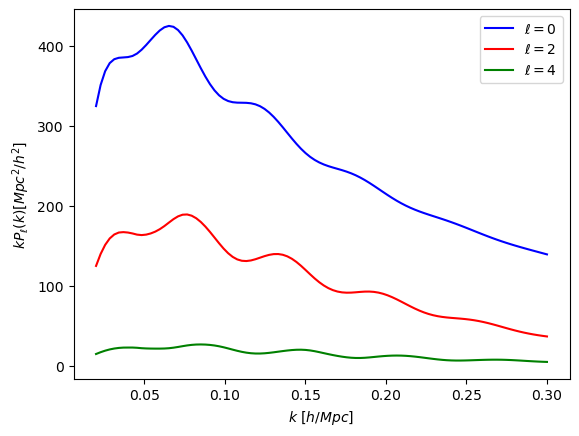

In [5]:
# You can also calculate the multipoles
for i, ell in enumerate([0, 2, 4]):
    plt.plot(k, k * m.pk_poles(k, ell=(ell,)), color=colors[i], label=f'$\\ell={ell}$')
    plt.legend()
    plt.xlabel(r'$k~[h/Mpc]$')
    plt.ylabel(r'$k P_{\ell}(k) [Mpc^2/h^2]$')

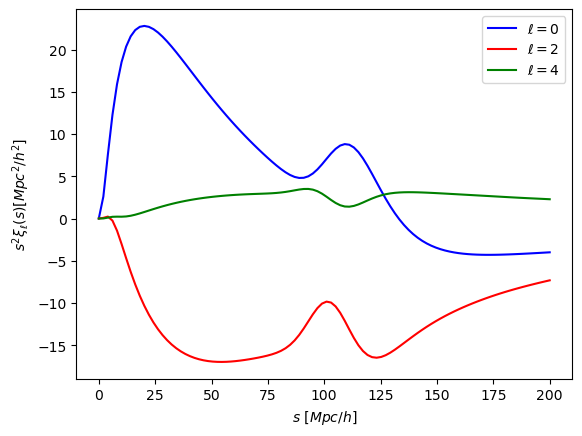

In [6]:
# And the multipoles in configuration space
s = np.linspace(0.01, 200, 100)
for i, ell in enumerate([0, 2, 4]):
    plt.plot(s, s**2 * m.xi_poles(s, ell=(ell,)), color=colors[i], label=f'$\\ell={ell}$')
    plt.legend()
    plt.xlabel(r'$s~[Mpc/h]$')
    plt.ylabel(r'$s^2 \xi_{\ell}(s) [Mpc^2/h^2]$')

## Fitter

In [7]:
fitter = Fitter(data=d,
                model=m,
                bb_exp=(-2, -1, 0, 1, 2), # exponents of the broad-band terms to use
               )         

#### Minimise chi2

In [8]:
min_chi2 = fitter.minimise_chi2() # it uses scipy.optimize internally
# note that the actual values in the model instance get updated automatically

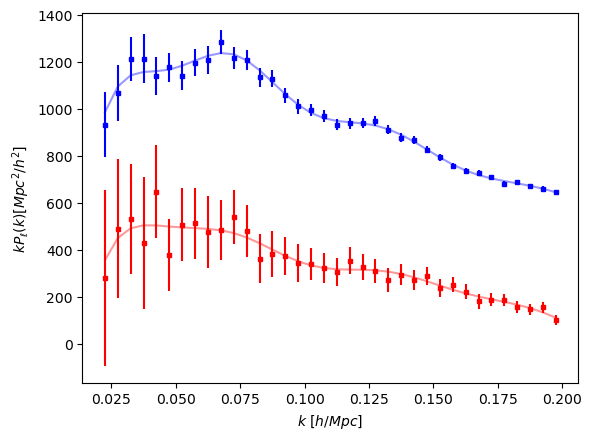

In [9]:
bb, coeff = fitter.broad_band() # returns the broadband terms, to be added to the model
err = np.sqrt(d.cov.diagonal())
n = len(d.k)
colors = ['b', 'r']
for i, ell in enumerate([0, 2]):
    plt.plot(d.k, d.k * (m.pk_poles(d.k, ell=(ell,)) + bb[i]), color=colors[i], alpha=0.4)
    yerr = err[i*n:(i+1)*n]
    plt.errorbar(d.k, d.k * d.poles[i], yerr=d.k * yerr, ls='', marker='s', markersize=3, color=colors[i])
    plt.xlabel(r'$k~[h/Mpc]$')
    plt.ylabel(r'$k P_{\ell}(k) [Mpc^2/h^2]$')

In [10]:
m.params

{'alpha_par': 0.9978461774613602,
 'alpha_perp': 1.000397752175429,
 'bias': 1.8629399894563134,
 'beta': 0.2752725218900471,
 'Sigma_par': 2.070950476755828,
 'Sigma_perp': 6.052636556868834,
 'Sigma_s': 1e-08}

#### Run sampler

The following code will be saved as *example.py*.

In [15]:
%%writefile './example.py'
import numpy as np
import sys
sys.path.append('../')
from bao_fitter import Data, Model, Fitter

d = Data(space='fourier', # can be fourier or configuration
         data_file='pk_multipoles.txt', 
         data_file_type='ascii', # a text file in this case, can use npy
         data_file_cols=(0,1,2),
         cov_file='covariance.npy', 
         cov_file_type='npy', # npy but can be ascii
         cov_npoles=2, # number of multipoles in the covariance file
         ell=(0,2), k_min=0.02, k_max=0.2, recon='recsym')

pk_lin = np.loadtxt('linearPk.txt', unpack=True)
m = Model(pk_linear=pk_lin)

f = Fitter(data=d,
           model=m,
           bb_exp=(-2, -1, 0, 1, 2), # exponents of the broad-band terms to use
           fixed_params={'Sigma_s':0., 'beta':0.3}, # you can specify if you want some of the parameters to be fixed
           )

# set gaussian priors, input mean and standard deviation
f.set_gaussian_prior('Sigma_par', 4., 2.)
f.set_gaussian_prior('Sigma_perp', 6., 2.)

f.set_sampler_settings(nchains=2,
                       epsilon=0.001, # R-1 for Gelman-Rubin
                       nmin=1000,
                       nmax=2000,
                      )

f.run_sampler(out_path='./')

Overwriting ./example.py


In [16]:
!mpirun -n 2 python example.py

Initial positions: 
 [[ 1.10291785  0.95312471  2.08145206  3.32867045 11.83038691]
 [ 0.95293846  1.13923888  2.67644188  4.8140572   8.48815825]
 [ 1.07121791  1.14879059  1.95998589  9.09127575  7.10654332]
 [ 1.06704495  0.94321407  1.62119729  4.51045675  2.26640065]
 [ 1.0605357   1.13566625  1.29015814  1.64255119 11.14827167]
 [ 1.00474613  1.10378084  2.83096185  9.89944585  4.71447151]
 [ 0.92538081  0.92351638  2.97775861  5.84199393  5.05160453]
 [ 0.88675709  0.9932236   2.98800206  9.05023211  8.48111308]
 [ 0.99540716  1.061527    1.27705164  7.4885962   3.80316435]
 [ 1.13274799  0.91149613  2.99857048  4.64547599  5.74537803]] 

Initial positions: 
 [[ 1.00949408  1.07010028  2.03656651  6.69641684  3.39213995]
 [ 1.00285721  1.07952623  2.00775541  7.35391921  7.6560601 ]
 [ 0.89644905  0.89254138  2.01262378  0.43391137  6.87121043]
 [ 1.00551153  1.14780763  1.77619568  2.88257648  8.84784542]
 [ 0.87418319  0.8618886   2.42030628 10.56436905 11.64528081]
 [ 1.03134

**Warning**: If you are running this on NERSC you should do:
```console
srun -n ntasks -c nthreads --cpu_bind=cores python example.py
```
However, don't run this from a jupyter notebook. Use an interactive job or create a script for sbatch.

Removed no burn in


<Figure size 600x450 with 0 Axes>

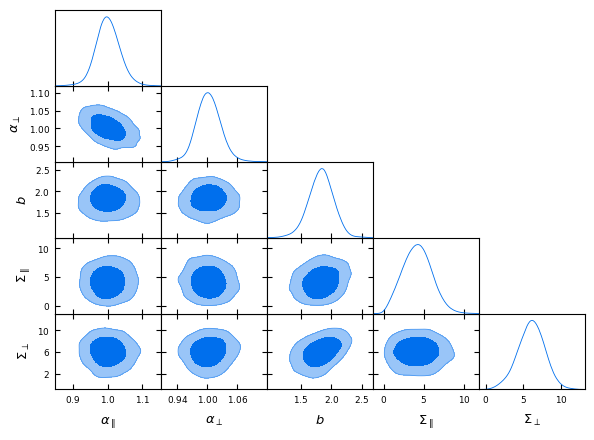

In [18]:
# You can post-process your chains however you want. This example uses getdist
from getdist import plots
from getdist import MCSamples

burnin = 0.3
chain_paths = [f'./chain_{i}.npy' for i in range(2)]
chain_list = []
for path in chain_paths:
    chain = np.load(path)
    nsteps, nwalkers, nparms = chain.shape
    istart = int(burnin*nsteps)
    chain = chain[istart:]
    nsteps = nsteps - istart
    chain = np.reshape(chain, (nsteps*nwalkers, nparms))
    chain_list.append(chain)
    
g = plots.get_single_plotter()
samples = MCSamples(samples=chain_list, names=[r'$\alpha_{\parallel}$',r'$\alpha_{\perp}$', r'$b$',
                                               r'$\Sigma_{\parallel}$', r'$\Sigma_{\perp}$'])
g.triangle_plot(samples, filled=True)